In [1]:
from dataclasses import dataclass, field
from typing import Optional
import sys
sys.path.append('/scratch/2023-fall-sp-le/langseg')

import torch
from torch import nn
from torch.nn import functional as F
torch.backends.cuda.matmul.allow_tf32 = True
from transformers import CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline

import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
from methods.prompt_engineering import extract_class_embeddings, extract_clip_text_embeddings
BICUBIC = InterpolationMode.BICUBIC

from datasets.coco_stuff import coco_stuff_categories, coco_stuff_171_to_27
from datasets.cityscapes import cat_to_label_id as cityscapes_cats
from datasets.utils import get_dataset
from utils.metrics import RunningScore
from utils.plotting import *

from methods.diffusion_patch import *
from methods.diffusion import *
from methods.diffusion_seg import *
from methods.diffusion_utils import *
from methods.text_embeddings import *
from methods.multilabel_classifiers import *
from methods.diffseg import *
from methods.exp_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
@dataclass
class SegmentationConfig:
    dir_dataset: str = field(
        default="/sinergia/ozaydin/segment/STEGO-master/data/cocostuff", metadata={"help": "dir dataset"}
    )
    dataset_name: str = field(
        default="coco_stuff", metadata={"help": "for get_dataset"}
    )
    split: str = field(
        default="val", metadata={"help": "which split to use"}
    )
    resolution: int = field(
        default=512, metadata={"help": "resolution of the images, e.g, 512, 768, 1024"}
    )
    mask_res: int = field(
        default=320, metadata={"help": "resolution of the masks, e.g, 64, 320, 512"}
    )
    dense_clip_arch: str = field(
        default="RN50x16", metadata={"help": "not used in cocostuff"}
    )

args = SegmentationConfig()

In [3]:
dataset, categories, palette = get_dataset(
    dir_dataset=args.dir_dataset,
    dataset_name=args.dataset_name,
    split=args.split,
    resolution=args.resolution,
    mask_res=args.mask_res,
    dense_clip_arch=args.dense_clip_arch
)

if args.dataset_name == "coco_stuff":
    label_id_to_cat = categories if not dataset.use_27 else coco_stuff_categories
    cat_to_label_id = {v: i for i, v in enumerate(label_id_to_cat)}
elif args.dataset_name == "cityscapes":
    cat_to_label_id = cityscapes_cats
    label_id_to_cat = {i: c for c, i in cat_to_label_id.items()}
elif args.dataset_name == "voc2012" or args.dataset_name == "pascal_context":
    label_id_to_cat = categories
    cat_to_label_id = {v: i for i, v in enumerate(label_id_to_cat)}

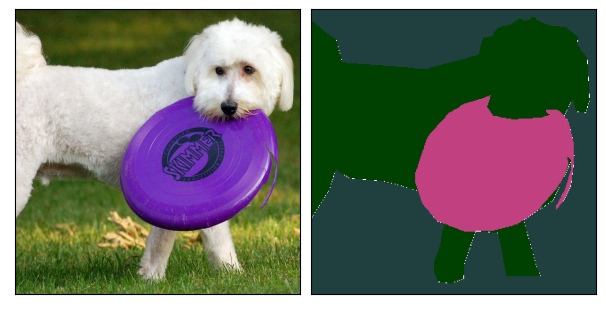

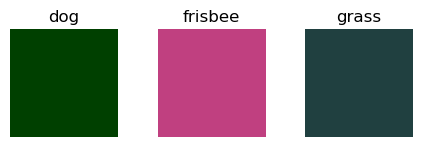

In [4]:
idxx = 58
val_img = dataset[idxx]["img"].cpu().numpy()
val_gt = dataset[idxx]["gt"].cpu().numpy()
lab_ids = sorted(list(np.unique(val_gt)))
lab_ids = np.array(lab_ids[1:])
val_pil_img = render_results(val_img, val_gt, palette)
_ = get_legends(lab_ids, palette, label_id_to_cat, is_voc2012 = args.dataset_name == "voc2012")

val_gt = dataset[idxx]["gt"].unsqueeze(0)
val_labels = sorted(np.unique(val_gt))
val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
val_labels = [label_id_to_cat[c] for c in val_labels]
val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input

In [5]:
import torch
from methods import gem
import requests
from PIL import Image

# model_name = 'ViT-B/16'  # 'ViT-B-16-quickgelu'
# pretrained = 'openai'  # 'metaclip_400m'
model_name = 'ViT-B/16-quickgelu'
# model_name = 'ViT-L/14-quickgelu'
pretrained = 'metaclip_400m'
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# init model and image transform
gem_model = gem.create_gem_model(model_name=model_name,
                                 pretrained=pretrained, 
                                 device=device)

In [6]:
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16,
    use_safetensors=True, variant="fp16",
    # device_map="auto"
)
pipe = pipe.to("cuda")
configure_ldm(pipe)

handles = {}
attention_layers_to_use = ATTENTION_LAYERS
attention_store = AttentionStore(low_resource=False, no_uncond=True, layer_keys=attention_layers_to_use)
attention_store.num_att_layers = len(attention_layers_to_use)
handles = register_attention_hooks(pipe.unet, attention_store, attention_layers_to_use, handles)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [7]:
# def get_image_and_labels(idx):
#     img_path = dataset[idx]["p_img"]
#     image = Image.open(img_path).convert('RGB').resize((1024, 1024))
#     val_gt = dataset[idx]["gt"].cpu().numpy()
#     val_labels = sorted(np.unique(val_gt))
#     val_labels = np.array([l for l in val_labels if l > 0])
#     y_true = np.zeros((len(label_id_to_cat),), dtype=np.int64)
#     y_true[val_labels] = 1
#     return image, y_true


# def get_pred_label_names(y_pred, candidate_labels):
#     label_preds = np.array(candidate_labels)[y_pred.astype(bool)]
#     assert len(label_preds) > 0
#     return label_preds.tolist()


# # clip_model_id = "openai/clip-vit-large-patch14"
# clip_model_id = "facebook/metaclip-h14-fullcc2.5b"
# clip_classifier = CLIPMultilabelClassifier(clip_model_id, label_id_to_cat)

# # del clip_classifier.clip_model.text_model
# # clip_classifier.clip_model.to(pipe.text_encoder.dtype)
# # clip_classifier.clip_model.text_model = pipe.text_encoder.text_model

# clip_classifier.init_text_embeds()
# del clip_classifier.clip_model.text_model

In [8]:
# # load image and text
# preprocess = gem.get_gem_img_transform(img_size=(448, 448))
# image = preprocess(Image.open(dataset[idxx]["p_img"])).unsqueeze(0).to(device)
# class_names = label_id_to_cat#[1:]
# with torch.no_grad():
#     logits = gem_model(image, class_names, normalize=False, return_ori=False)  # [1, num_class, W, H]

In [9]:
# normed_logits = gem_model.min_max(logits)
# gem.visualize(image, class_names, normed_logits)  # (optional visualization)

In [ ]:
def run_gem_voc():
    preprocess = gem.get_gem_img_transform(img_size=(448, 448))
    pbar = tqdm(range(len(dataset)))
    remapping = torch.tensor(list(coco_stuff_171_to_27.keys())).cuda(), torch.tensor(list(coco_stuff_171_to_27.values())).cuda()

    rscores = [RunningScore(len(coco_stuff_categories)) for i in range(7)]

    cls_gt = []
    cls_pred_0 = []
    cls_pred_2 = []

    # 0: CA @ SA
    # 1: CA @ SA & GT class names
    # 2: CA only
    # 3: CA only & GT class names
    # 4: Labeling GT clusters with cluster-avg CA
    # 5: labeling diffseg clusters with cluster-avg CA 
    for idx in pbar:
        val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
        val_gt = dataset[idx]["gt"].unsqueeze(0)
        val_labels = sorted(np.unique(val_gt))
        val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
        val_labels = [label_id_to_cat[c] for c in val_labels]
        val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input

        # # multilabel classification (does not work)
        # image, y_true = get_image_and_labels(idx)
        # y_pred, _ = clip_classifier.forward_v2(image, choice=(8,8), clf_thresh=0.25)
        # y_pred = y_pred.cpu().numpy()
        # val_labels = get_pred_label_names(y_pred, label_id_to_cat)

        # load image and text
        image = preprocess(Image.open(dataset[idx]["p_img"]).convert("RGB")).unsqueeze(0).to(device)
        class_names = label_id_to_cat

        with torch.no_grad():
            logits01 = gem_model(image, class_names, output_size=64, normalize=False)  # [1, num_class, W, H]

        # CA only
        logits23456 = F.interpolate(logits01, size=320, mode='bilinear')
        logits23456 = (logits23456*100).softmax(dim=1)
        pred2 = logits23456.argmax(dim=1)
        pred3 = filter_prompt(logits23456, val_labels, cat_to_label_id).argmax(dim=1)
        pred4 = label_clusters(val_gt, logits23456)

        # CA @ SA
        val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
        attention_store.reset()
        text_embeds = get_text_embeddings_simple(pipe.tokenizer, pipe.text_encoder, "")
        val_img = val_img.repeat(len(text_embeds), axis=0)
        training_step(pipe, text_embeds, val_img, attention_store, no_uncond=True, normalize=False, low_resource=False, timestep=100)
        ca, sa = get_attention_maps(
            attention_store.get_average_attention(),
            batch_size=len(text_embeds),
            label_indices=None,
            output_size=64,
            average_layers=True,
            apply_softmax=True,
            softmax_dim=-1,
            simple_average=False
        )
        pred5 = diffseg(sa, refine=True)
        pred5 = label_clusters(pred5, logits23456)
        pred6 = get_specclust_mask(
            logits23456.permute(0, 2, 3, 1).view(1, -1, logits23456.shape[1]), sa, cat_to_label_id,
            list(range(len(label_id_to_cat))), label_id_to_cat,
            output_size=args.mask_res, minmax_norm=False
        ).long()

        ca0 = (logits01 * 100).softmax(dim=1)
        ca0 = ca0.view(*ca0.shape[:2], -1).permute(0, 2, 1)
        agg_map0 = get_agg_map(ca0, sa, minmax_norm=False, ca_norm=False)
        agg_map0 = upscale_attn(agg_map0, 320)
        pred0 = agg_map0.argmax(dim=-1)

        ca1 = (filter_prompt(logits01, val_labels, cat_to_label_id) * 100).softmax(dim=1)
        ca1 = ca1.view(*ca1.shape[:2], -1).permute(0, 2, 1)
        agg_map1 = get_agg_map(ca1, sa, minmax_norm=False, ca_norm=False)
        agg_map1 = upscale_attn(agg_map1, 320)
        pred1 = agg_map1.argmax(dim=-1)
        
        # multilabel classification
        cls_gt.append(val_gt.unique().tolist())
        cls_pred_0.append(pred0.unique().tolist())
        cls_pred_2.append(pred2.unique().tolist())

        # cocostuff-27 evaluation
        coarse_val_gt = remap_values(remapping, val_gt.cuda())
        coarse_val_gt[val_gt == -1] = -1
        val_gt = coarse_val_gt
        pred0 = remap_values(remapping, pred0)
        pred1 = remap_values(remapping, pred1)
        pred2 = remap_values(remapping, pred2)
        pred3 = remap_values(remapping, pred3)
        pred4 = remap_values(remapping, pred4)
        pred5 = remap_values(remapping, pred5)
        pred6 = remap_values(remapping, pred6)

        for rs, pred in zip(rscores, [pred0, pred1, pred2, pred3, pred4, pred5, pred6]):
            rs.update(val_gt.cpu().numpy(), pred.cpu().numpy())

        mious = []
        for rs in rscores:
            metrics, _ = rs.get_scores()
            mious.append(metrics["Mean IoU"])

        description = " | ".join([f"mIoU_{i} {mious[i]:.3f}" for i in range(len(mious))])
        pbar.set_description(description)

    return rscores, (cls_gt, cls_pred_0, cls_pred_2)

with np.errstate(divide='ignore', invalid='ignore'):
    rs, cls_multilabel = run_gem_voc()

val mIoU_0 0.396 | mIoU_1 0.445 | mIoU_2 0.382 | mIoU_3 0.440 | mIoU_4 0.467 | mIoU_5 0.387 | mIoU_6 0.393

### val results

{'Pixel Acc': '61.3', 'Mean Acc': '58.0', 'FreqW Acc': '45.8', 'Mean IoU': '39.6'}
{'person': '47.3', 'bicycle': '22.2', 'car': '47.0', 'motorcycle': '32.6', 'airplane': '48.2', 'bus': '19.4', 'train': '37.9', 'truck': '74.5', 'boat': '37.0', 'traffic light': '47.3', 'fire hydrant': '23.0', 'stop sign': '62.7', 'parking meter': '35.5', 'bench': '29.9', 'bird': '34.1', 'cat': '28.0', 'dog': '6.8', 'horse': '21.0', 'sheep': '29.4', 'cow': '33.9', 'elephant': '40.1', 'bear': '47.8', 'zebra': '60.1', 'giraffe': '67.0', 'backpack': '30.0', 'umbrella': '38.2', 'handbag': '69.3'}

####################################################################################################

{'Pixel Acc': '65.5', 'Mean Acc': '63.0', 'FreqW Acc': '50.1', 'Mean IoU': '44.5'}
{'person': '46.2', 'bicycle': '27.9', 'car': '51.2', 'motorcycle': '35.3', 'airplane': '52.7', 'bus': '27.4', 'train': '48.1', 'truck': '76.5', 'boat': '43.6', 'traffic light': '53.4', 'fire hydrant': '15.5', 'stop sign': '65.6', 'parking meter': '40.9', 'bench': '38.1', 'bird': '38.8', 'cat': '32.3', 'dog': '13.9', 'horse': '31.0', 'sheep': '28.4', 'cow': '40.9', 'elephant': '48.4', 'bear': '51.7', 'zebra': '66.2', 'giraffe': '67.6', 'backpack': '47.1', 'umbrella': '41.7', 'handbag': '72.5'}

####################################################################################################

{'Pixel Acc': '59.7', 'Mean Acc': '56.5', 'FreqW Acc': '44.4', 'Mean IoU': '38.2'}
{'person': '46.3', 'bicycle': '22.8', 'car': '45.4', 'motorcycle': '32.6', 'airplane': '45.2', 'bus': '20.7', 'train': '36.9', 'truck': '74.1', 'boat': '34.1', 'traffic light': '47.5', 'fire hydrant': '22.4', 'stop sign': '63.0', 'parking meter': '35.6', 'bench': '28.7', 'bird': '32.8', 'cat': '27.8', 'dog': '6.8', 'horse': '20.2', 'sheep': '27.7', 'cow': '31.1', 'elephant': '40.2', 'bear': '46.3', 'zebra': '58.9', 'giraffe': '62.0', 'backpack': '20.7', 'umbrella': '34.0', 'handbag': '67.9'}

####################################################################################################

{'Pixel Acc': '64.8', 'Mean Acc': '63.2', 'FreqW Acc': '49.2', 'Mean IoU': '44.0'}
{'person': '47.9', 'bicycle': '28.6', 'car': '51.2', 'motorcycle': '36.0', 'airplane': '51.3', 'bus': '30.1', 'train': '45.8', 'truck': '73.9', 'boat': '41.6', 'traffic light': '51.9', 'fire hydrant': '16.6', 'stop sign': '64.5', 'parking meter': '41.2', 'bench': '37.7', 'bird': '38.4', 'cat': '32.3', 'dog': '14.9', 'horse': '29.8', 'sheep': '28.0', 'cow': '39.1', 'elephant': '49.2', 'bear': '51.1', 'zebra': '65.2', 'giraffe': '63.4', 'backpack': '46.7', 'umbrella': '39.9', 'handbag': '71.6'}

####################################################################################################

{'Pixel Acc': '67.3', 'Mean Acc': '64.5', 'FreqW Acc': '52.8', 'Mean IoU': '46.7'}
{'person': '63.6', 'bicycle': '24.0', 'car': '52.8', 'motorcycle': '38.6', 'airplane': '59.5', 'bus': '24.0', 'train': '45.0', 'truck': '92.0', 'boat': '45.4', 'traffic light': '62.4', 'fire hydrant': '31.5', 'stop sign': '76.6', 'parking meter': '38.9', 'bench': '35.1', 'bird': '38.0', 'cat': '32.5', 'dog': '8.1', 'horse': '26.4', 'sheep': '33.2', 'cow': '40.7', 'elephant': '46.2', 'bear': '52.8', 'zebra': '66.8', 'giraffe': '73.7', 'backpack': '33.0', 'umbrella': '47.1', 'handbag': '73.4'}

####################################################################################################

{'Pixel Acc': '60.6', 'Mean Acc': '57.2', 'FreqW Acc': '45.1', 'Mean IoU': '38.7'}
{'person': '46.5', 'bicycle': '22.2', 'car': '46.3', 'motorcycle': '32.2', 'airplane': '47.1', 'bus': '18.2', 'train': '35.1', 'truck': '71.3', 'boat': '34.9', 'traffic light': '46.2', 'fire hydrant': '20.5', 'stop sign': '60.5', 'parking meter': '35.1', 'bench': '29.3', 'bird': '33.1', 'cat': '27.6', 'dog': '6.8', 'horse': '20.5', 'sheep': '29.6', 'cow': '33.7', 'elephant': '40.0', 'bear': '47.6', 'zebra': '58.8', 'giraffe': '66.6', 'backpack': '28.6', 'umbrella': '37.2', 'handbag': '69.2'}

####################################################################################################

{'Pixel Acc': '61.1', 'Mean Acc': '57.7', 'FreqW Acc': '45.7', 'Mean IoU': '39.3'}
{'person': '46.6', 'bicycle': '22.6', 'car': '46.1', 'motorcycle': '31.9', 'airplane': '46.5', 'bus': '19.4', 'train': '36.2', 'truck': '73.7', 'boat': '36.0', 'traffic light': '46.8', 'fire hydrant': '22.6', 'stop sign': '62.0', 'parking meter': '36.9', 'bench': '29.5', 'bird': '33.4', 'cat': '27.9', 'dog': '6.9', 'horse': '21.1', 'sheep': '30.2', 'cow': '32.9', 'elephant': '40.1', 'bear': '47.9', 'zebra': '60.3', 'giraffe': '66.8', 'backpack': '28.4', 'umbrella': '38.0', 'handbag': '69.5'}

####################################################################################################

In [ ]:
for i in range(len(rs)):
    metrics, cls_iou = rs[i].get_scores() # original results
    print({k: f"{v*100:.1f}" for k, v in metrics.items()})
    print({label_id_to_cat[i]: f"{v*100:.1f}" for i, v in cls_iou.items()})
    print("#" * 100)

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, multilabel_confusion_matrix, accuracy_score

def binarize_multilabel(labels, n_classes):
    # labels: list of list
    label_array = np.zeros((len(labels), n_classes))
    for i, label in enumerate(labels):
        label = [l for l in label if l != -1]
        label_array[i, label] = 1
    return label_array

cls_gt, cls_pred_0, cls_pred_2 = cls_multilabel
y_true = binarize_multilabel(cls_gt, len(label_id_to_cat))
y_pred0 = binarize_multilabel(cls_pred_0, len(label_id_to_cat))
y_pred2 = binarize_multilabel(cls_pred_2, len(label_id_to_cat))

pr0 = precision_score(y_true, y_pred0, average="macro")
rc0 = recall_score(y_true, y_pred0, average="macro")
pr2 = precision_score(y_true, y_pred2, average="macro")
rc2 = recall_score(y_true, y_pred2, average="macro")

print("Average precision 0 {:.3f}, average recall 0 {:.3f}".format(pr0, rc0))
print("Average precision 2 {:.3f}, average recall 2 {:.3f}".format(pr2, rc2))

val results

Average precision 0 0.618, average recall 0 0.344

Average precision 2 0.514, average recall 2 0.478

In [ ]:
print(classification_report(y_true, y_pred0))

    precision    recall  f1-score   support

           0       0.98      0.49      0.66      2300
           1       0.79      0.49      0.60       133
           2       0.80      0.35      0.48       496
           3       0.89      0.71      0.79       143
           4       0.96      0.83      0.89        88
           5       0.88      0.69      0.77       176
           6       0.94      0.81      0.87       140
           7       0.58      0.37      0.45       231
           8       0.91      0.72      0.80       107
           9       0.69      0.13      0.21       173
          10       0.89      0.43      0.58        77
          11       0.38      0.53      0.44        62
          12       0.75      0.34      0.47        35
          13       0.59      0.46      0.52       211
          14       0.94      0.54      0.69       115
          15       0.95      0.84      0.89       134
          16       0.86      0.74      0.79       133
          17       0.91      0.85      0.88       120
          18       0.94      0.77      0.84        60
          19       0.68      0.83      0.75        81
          20       0.92      0.96      0.94        79
          21       0.81      0.91      0.86        46
          22       0.96      0.97      0.97        71
          23       0.98      0.89      0.93        93
          24       0.56      0.18      0.28       196
          25       0.96      0.63      0.76       161
          26       0.83      0.12      0.20       257
          27       0.40      0.52      0.45        66
          28       0.88      0.43      0.58        88
          29       0.79      0.44      0.56        71
          30       0.86      0.33      0.47       110
          31       0.53      0.22      0.31        45
          32       0.51      0.42      0.46       138
          33       0.82      0.66      0.73        76
          34       0.82      0.34      0.48        83
          35       0.82      0.11      0.20        79
          36       0.89      0.56      0.68       113
          37       0.98      0.36      0.52       137
          38       1.00      0.65      0.79       142
          39       0.67      0.14      0.23       306
          40       0.77      0.21      0.33        82
          41       1.00      0.03      0.07       287
          42       1.00      0.13      0.23        77
          43       0.15      0.02      0.03       112
          44       0.50      0.07      0.13        95
          45       0.46      0.17      0.25       210
          46       0.56      0.60      0.58        73
          47       0.80      0.08      0.15        48
          48       0.71      0.33      0.45        52
          49       0.21      0.23      0.22        53
          50       0.89      0.46      0.61        37
          51       1.00      0.19      0.32        52
          52       0.83      0.16      0.27        31
          53       0.96      0.70      0.81        91
          54       0.88      0.36      0.51        39
          55       0.69      0.70      0.70        80
          56       0.73      0.20      0.32       480
          57       0.76      0.74      0.75       161
          58       0.60      0.41      0.49       150
          59       0.83      0.77      0.80       103
          60       0.67      0.45      0.54       309
          61       0.92      0.72      0.81       136
          62       0.97      0.35      0.51       182
          63       0.83      0.64      0.73       152
          64       0.00      0.00      0.00        80
          65       0.28      0.08      0.12       117
          66       0.81      0.23      0.36        95
          67       0.62      0.20      0.31       128
          68       1.00      0.17      0.29        48
          69       0.61      0.43      0.51        99
          70       0.50      0.14      0.22         7
          71       0.68      0.60      0.63       173
          72       1.00      0.26      0.41        89
          73       0.72      0.15      0.25       191
          74       0.95      0.40      0.56       192
          75       0.84      0.33      0.47       116
          76       1.00      0.40      0.57        25
          77       0.72      0.72      0.72        61
          78       0.67      0.25      0.36         8
          79       0.60      0.14      0.23        21
          80       0.36      0.15      0.21       123
          81       0.37      0.32      0.34        91
          82       0.00      0.00      0.00        89
          83       0.32      0.42      0.37        78
          84       0.71      0.38      0.50       918
          85       0.36      0.40      0.38       441
          86       0.56      0.43      0.49       269
          87       0.24      0.04      0.07       118
          88       0.80      0.18      0.29       202
          89       0.73      0.38      0.50       154
          90       0.82      0.45      0.58       370
          91       0.00      0.00      0.00        11
          92       0.11      0.01      0.02       102
          93       0.80      0.14      0.24      1118
          94       0.74      0.31      0.44       327
          95       0.23      0.69      0.34       145
          96       0.05      0.21      0.08        19
          97       0.89      0.46      0.61       189
          98       0.45      0.65      0.53       134
          99       0.65      0.05      0.09       399
         100       0.73      0.11      0.19       329
         101       0.52      0.39      0.44       397
         102       0.14      0.07      0.09        46
         103       0.22      0.45      0.30       350
         104       0.06      0.02      0.03        56
         105       0.89      0.03      0.06       273
         106       0.85      0.16      0.26       211
         107       0.55      0.43      0.48       109
         108       0.67      0.14      0.24       111
         109       0.55      0.59      0.57       257
         110       0.52      0.33      0.40        83
         111       0.81      0.24      0.37       891
         112       0.78      0.45      0.57       856
         113       0.47      0.14      0.21       103
         114       0.09      0.26      0.13       151
         115       0.23      0.47      0.31       100
         116       0.39      0.24      0.30       261
         117       0.36      0.17      0.23       139
         118       0.39      0.08      0.13       411
         119       0.05      0.08      0.06        25
         120       0.86      0.01      0.02      1293
         121       0.53      0.50      0.51       129
         122       0.00      0.00      0.00         7
         123       0.73      0.53      0.61       173
         124       0.09      0.20      0.12        15
         125       0.26      0.20      0.22        46
         126       0.34      0.37      0.35        49
         127       0.60      0.01      0.01       426
         128       0.75      0.56      0.64       763
         129       0.26      0.09      0.13        58
         130       0.41      0.05      0.08       329
         131       0.93      0.02      0.04       673
         132       0.13      0.47      0.20       100
         133       0.67      0.02      0.04       196
         134       0.27      0.10      0.15        58
         135       0.98      0.52      0.68       112
         136       0.53      0.77      0.63        81
         137       0.60      0.75      0.67       601
         138       0.59      0.35      0.44       131
         139       0.31      0.09      0.14       158
         140       0.75      0.18      0.29       100
         141       0.21      0.18      0.19        17
         142       0.95      0.48      0.64       186
         143       0.95      0.76      0.84       259
         144       0.70      0.09      0.16       212
         145       0.73      0.49      0.58      1194
         146       0.48      0.52      0.50        67
         147       0.90      0.98      0.93       166
         148       0.02      0.11      0.03        35
         149       0.56      0.21      0.31        86
         150       0.07      0.02      0.03        59
         151       0.50      0.13      0.21        61
         152       0.04      0.01      0.01       172
         153       0.57      0.59      0.58       564
         154       0.22      0.24      0.23        58
         155       0.46      0.02      0.04       523
         156       0.52      0.16      0.24       108
         157       0.90      0.37      0.52      1412
         158       0.80      0.17      0.29        69
         159       0.89      0.13      0.23       194
         160       0.63      0.03      0.05      1167
         161       0.25      0.19      0.21       556
         162       0.00      0.00      0.00       151
         163       0.29      0.30      0.29        84
         164       1.00      0.14      0.25       201
         165       0.57      0.18      0.27       285
         166       0.25      0.38      0.30        74
         167       0.12      0.14      0.13         7
         168       0.93      0.17      0.29        76
         169       0.68      0.31      0.42       467
         170       0.53      0.13      0.20       190

   micro avg       0.62      0.33      0.43     36568
   macro avg       0.62      0.34      0.40     36568
weighted avg       0.69      0.33      0.40     36568
 samples avg       0.65      0.38      0.45     36568

In [ ]:
print(classification_report(y_true, y_pred2))

precision    recall  f1-score   support

           0       0.90      0.67      0.77      2300
           1       0.66      0.58      0.62       133
           2       0.68      0.48      0.56       496
           3       0.73      0.80      0.76       143
           4       0.90      0.93      0.92        88
           5       0.80      0.77      0.78       176
           6       0.90      0.89      0.90       140
           7       0.41      0.47      0.44       231
           8       0.66      0.85      0.75       107
           9       0.56      0.27      0.36       173
          10       0.80      0.57      0.67        77
          11       0.26      0.61      0.36        62
          12       0.55      0.49      0.52        35
          13       0.36      0.59      0.45       211
          14       0.70      0.62      0.66       115
          15       0.87      0.86      0.86       134
          16       0.65      0.81      0.72       133
          17       0.64      0.88      0.74       120
          18       0.89      0.80      0.84        60
          19       0.34      0.94      0.50        81
          20       0.61      0.97      0.75        79
          21       0.51      0.98      0.67        46
          22       0.84      0.97      0.90        71
          23       0.97      0.97      0.97        93
          24       0.41      0.32      0.36       196
          25       0.88      0.70      0.78       161
          26       0.75      0.20      0.31       257
          27       0.29      0.62      0.39        66
          28       0.64      0.65      0.64        88
          29       0.44      0.62      0.51        71
          30       0.84      0.69      0.76       110
          31       0.46      0.51      0.48        45
          32       0.44      0.67      0.53       138
          33       0.71      0.79      0.75        76
          34       0.62      0.59      0.60        83
          35       0.74      0.22      0.33        79
          36       0.82      0.81      0.81       113
          37       0.93      0.56      0.70       137
          38       1.00      0.77      0.87       142
          39       0.51      0.23      0.32       306
          40       0.68      0.30      0.42        82
          41       0.84      0.09      0.17       287
          42       0.56      0.19      0.29        77
          43       0.16      0.07      0.10       112
          44       0.34      0.13      0.18        95
          45       0.35      0.26      0.30       210
          46       0.22      0.71      0.34        73
          47       0.71      0.10      0.18        48
          48       0.71      0.52      0.60        52
          49       0.11      0.38      0.17        53
          50       0.76      0.68      0.71        37
          51       0.91      0.38      0.54        52
          52       0.92      0.35      0.51        31
          53       0.88      0.79      0.83        91
          54       0.77      0.44      0.56        39
          55       0.43      0.78      0.55        80
          56       0.62      0.37      0.46       480
          57       0.61      0.85      0.71       161
          58       0.44      0.55      0.49       150
          59       0.62      0.85      0.72       103
          60       0.56      0.60      0.58       309
          61       0.85      0.85      0.85       136
          62       0.91      0.47      0.62       182
          63       0.78      0.72      0.75       152
          64       0.30      0.04      0.07        80
          65       0.37      0.25      0.30       117
          66       0.77      0.36      0.49        95
          67       0.50      0.30      0.37       128
          68       0.92      0.23      0.37        48
          69       0.49      0.71      0.58        99
          70       0.06      0.14      0.08         7
          71       0.60      0.72      0.66       173
          72       0.87      0.44      0.58        89
          73       0.70      0.26      0.38       191
          74       0.90      0.51      0.65       192
          75       0.71      0.39      0.50       116
          76       1.00      0.48      0.65        25
          77       0.47      0.74      0.57        61
          78       0.40      0.25      0.31         8
          79       0.60      0.29      0.39        21
          80       0.22      0.36      0.27       123
          81       0.30      0.58      0.40        91
          82       0.43      0.07      0.12        89
          83       0.18      0.64      0.28        78
          84       0.61      0.55      0.58       918
          85       0.30      0.62      0.41       441
          86       0.38      0.70      0.49       269
          87       0.32      0.19      0.24       118
          88       0.61      0.22      0.33       202
          89       0.63      0.56      0.60       154
          90       0.72      0.65      0.68       370
          91       0.00      0.00      0.00        11
          92       0.07      0.02      0.03       102
          93       0.77      0.28      0.41      1118
          94       0.67      0.48      0.56       327
          95       0.14      0.90      0.25       145
          96       0.03      0.37      0.05        19
          97       0.78      0.56      0.65       189
          98       0.33      0.78      0.47       134
          99       0.59      0.15      0.24       399
         100       0.58      0.25      0.35       329
         101       0.45      0.55      0.49       397
         102       0.09      0.09      0.09        46
         103       0.16      0.77      0.26       350
         104       0.10      0.07      0.08        56
         105       0.94      0.11      0.19       273
         106       0.69      0.31      0.43       211
         107       0.24      0.61      0.35       109
         108       0.34      0.21      0.26       111
         109       0.50      0.80      0.61       257
         110       0.44      0.45      0.44        83
         111       0.72      0.42      0.53       891
         112       0.74      0.57      0.65       856
         113       0.31      0.19      0.24       103
         114       0.08      0.50      0.14       151
         115       0.11      0.70      0.18       100
         116       0.30      0.40      0.34       261
         117       0.23      0.35      0.27       139
         118       0.24      0.57      0.33       411
         119       0.03      0.20      0.05        25
         120       0.67      0.02      0.05      1293
         121       0.32      0.69      0.44       129
         122       0.06      0.14      0.08         7
         123       0.47      0.66      0.55       173
         124       0.05      0.40      0.08        15
         125       0.23      0.30      0.26        46
         126       0.16      0.73      0.27        49
         127       0.70      0.04      0.07       426
         128       0.67      0.72      0.69       763
         129       0.20      0.21      0.20        58
         130       0.29      0.32      0.31       329
         131       0.70      0.04      0.08       673
         132       0.08      0.69      0.14       100
         133       0.43      0.13      0.20       196
         134       0.14      0.12      0.13        58
         135       0.95      0.71      0.82       112
         136       0.46      0.89      0.61        81
         137       0.41      0.97      0.58       601
         138       0.48      0.45      0.47       131
         139       0.24      0.21      0.22       158
         140       0.59      0.27      0.37       100
         141       0.16      0.35      0.22        17
         142       0.90      0.60      0.72       186
         143       0.71      0.95      0.81       259
         144       0.67      0.17      0.27       212
         145       0.63      0.74      0.68      1194
         146       0.39      0.69      0.49        67
         147       0.75      0.99      0.85       166
         148       0.01      0.91      0.02        35
         149       0.35      0.28      0.31        86
         150       0.14      0.12      0.13        59
         151       0.29      0.20      0.23        61
         152       0.06      0.09      0.07       172
         153       0.43      0.83      0.57       564
         154       0.13      0.36      0.19        58
         155       0.39      0.05      0.09       523
         156       0.60      0.29      0.39       108
         157       0.88      0.50      0.64      1412
         158       0.56      0.36      0.44        69
         159       0.73      0.19      0.30       194
         160       0.58      0.05      0.10      1167
         161       0.26      0.35      0.30       556
         162       0.00      0.00      0.00       151
         163       0.21      0.45      0.29        84
         164       0.92      0.23      0.37       201
         165       0.44      0.32      0.37       285
         166       0.18      0.66      0.28        74
         167       0.02      0.14      0.04         7
         168       0.95      0.28      0.43        76
         169       0.59      0.45      0.51       467
         170       0.32      0.24      0.27       190

   micro avg       0.42      0.47      0.44     36568
   macro avg       0.51      0.48      0.44     36568
weighted avg       0.60      0.47      0.46     36568
 samples avg       0.45      0.52      0.45     36568

In [ ]:
def avg_fpr(y_true, y_pred):
    conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

    # Calculate False Positive Rate for each class
    false_positive_rates = []

    for i in range(len(conf_matrices)):
        false_positive_rate = conf_matrices[i][0, 1] / (conf_matrices[i][0, 1] + conf_matrices[i][0, 0])
        false_positive_rates.append(false_positive_rate)

    # Calculate the average false positive rate
    average_false_positive_rate = sum(false_positive_rates) / len(false_positive_rates)

    print("Average False Positive Rate:", average_false_positive_rate)

avg_fpr(y_true, y_pred0)
avg_fpr(y_true, y_pred2)

val results

Average False Positive Rate: 0.011227833414851954

Average False Positive Rate: 0.035503899285815495